In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import label_binarize
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In [4]:
# Load dataset
wine = load_wine()
features = pd.DataFrame(wine.data, columns=wine.feature_names)
target = pd.DataFrame(wine.target, columns=['label'])
df = pd.concat([features, target], axis=1)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,label
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [6]:
print('Shape of the Dataset:', df.shape)

Shape of the Dataset: (178, 14)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  label

In [10]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,label
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


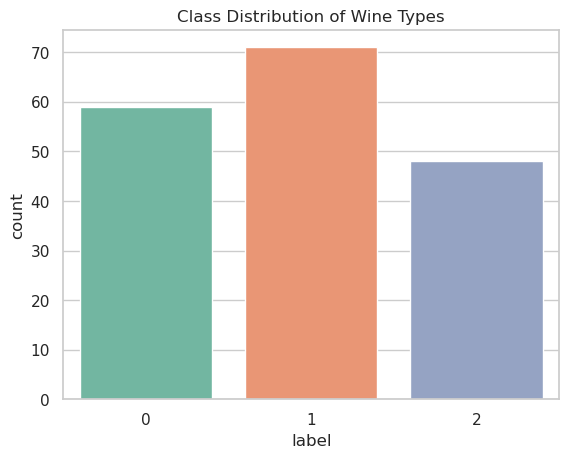

Class Distribution: label
1    71
0    59
2    48
Name: count, dtype: int64


In [12]:
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Class Distribution of Wine Types')
plt.show()
print('Class Distribution:', df['label'].value_counts())

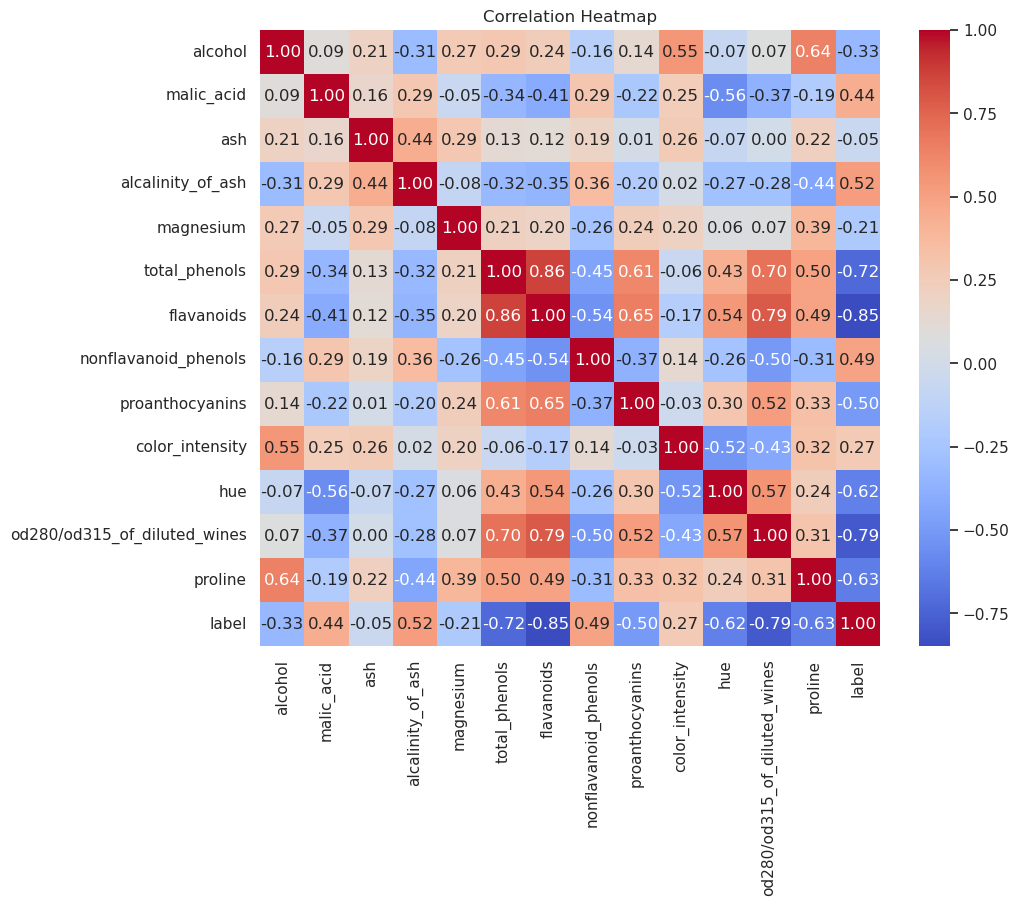

In [14]:
corr_matrix = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

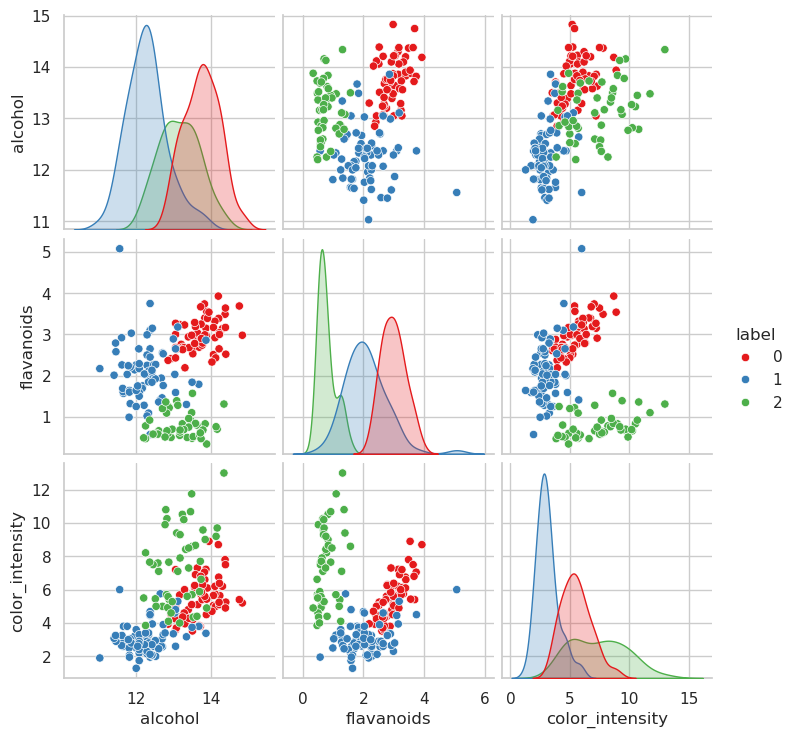

In [16]:
# visualize top correlated features
sns.pairplot(df, vars=['alcohol','flavanoids','color_intensity'], hue='label', palette='Set1')
plt.show()

In [21]:
# Start Spark session
spark = SparkSession.builder.appName('WineClassification').getOrCreate()

# Convert pandas DataFrame to Spark DataFrame
sdf = spark.createDataFrame(df)
sdf.printSchema()
sdf.show(5)

root
 |-- alcohol: double (nullable = true)
 |-- malic_acid: double (nullable = true)
 |-- ash: double (nullable = true)
 |-- alcalinity_of_ash: double (nullable = true)
 |-- magnesium: double (nullable = true)
 |-- total_phenols: double (nullable = true)
 |-- flavanoids: double (nullable = true)
 |-- nonflavanoid_phenols: double (nullable = true)
 |-- proanthocyanins: double (nullable = true)
 |-- color_intensity: double (nullable = true)
 |-- hue: double (nullable = true)
 |-- od280/od315_of_diluted_wines: double (nullable = true)
 |-- proline: double (nullable = true)
 |-- label: long (nullable = true)

+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+-----+
|alcohol|malic_acid| ash|alcalinity_of_ash|magnesium|total_phenols|flavanoids|nonflavanoid_phenols|proanthocyanins|color_intensity| hue|od280/od315_of_diluted_wines|proline|label|
+-------+----------+----+-

In [24]:
# Feature Engineering
feature_cols = wine.feature_names
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features_raw')
scaler = StandardScaler(inputCol='features_raw', outputCol='features', withMean=True, withStd=True)
indexer = StringIndexer(inputCol='label', outputCol='indexedLabel', handleInvalid='skip')

# Create transformed data
data = assembler.transform(sdf)
data = scaler.fit(data).transform(data)
data = indexer.fit(data).transform(data)

# Final dataset
data = data.select('features', 'indexedLabel')
data.show(5)

+--------------------+------------+
|            features|indexedLabel|
+--------------------+------------+
|[1.51434076729214...|         1.0|
|[0.24559682781701...|         1.0|
|[0.19632521851701...|         1.0|
|[1.68679139984215...|         1.0|
|[0.29486843711702...|         1.0|
+--------------------+------------+
only showing top 5 rows


In [25]:
# Create Random Forest pipeline
# If data already has 'features' and 'indexedLabel', use simple pipelines
rf = RandomForestClassifier(featuresCol='features', labelCol='indexedLabel', seed=42)
lr = LogisticRegression(featuresCol='features', labelCol='indexedLabel', maxIter=100)

# Simple pipelines without transformation stages
pipeline_rf = Pipeline(stages=[rf])
pipeline_lr = Pipeline(stages=[lr])

In [28]:
# Train-Test Split
train, test = data.randomSplit([0.8, 0.2], seed=42)
print(f"Training data count: {train.count()}, Test data count: {test.count()}")

Training data count: 145, Test data count: 33


In [29]:
# Parameter Grid for RandomForest
paramGrid_rf = (ParamGridBuilder()
    .addGrid(rf.numTrees, [50, 100])
    .addGrid(rf.maxDepth, [5, 10])
    .build())

# Parameter Grid for LogisticRegression
paramGrid_lr = (ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.1, 0.5])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .build())

# CrossValidator
evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel', predictionCol='prediction', metricName='accuracy')
cv_rf = CrossValidator(estimator=pipeline_rf, estimatorParamMaps=paramGrid_rf, evaluator=evaluator, numFolds=3, parallelism=2)
cv_lr = CrossValidator(estimator=pipeline_lr, estimatorParamMaps=paramGrid_lr, evaluator=evaluator, numFolds=3, parallelism=2)

# Fit the models
cv_model_rf = cv_rf.fit(train)
cv_model_lr = cv_lr.fit(train)

# Best models
best_rf = cv_model_rf.bestModel
best_lr = cv_model_lr.bestModel

print("Model training completed successfully!")

25/11/18 18:44:28 WARN BlockManager: Block rdd_62_0 already exists on this machine; not re-adding it


Model training completed successfully!


In [32]:
# Predictions
pred_rf = best_rf.transform(test)
pred_lr = best_lr.transform(test)

# Collect true labels, predictions
y_true_rf = np.array([int(r['indexedLabel']) for r in pred_rf.select('indexedLabel').collect()])
y_pred_rf = np.array([int(r['prediction']) for r in pred_rf.select('prediction').collect()])
y_true_lr = np.array([int(r['indexedLabel']) for r in pred_lr.select('indexedLabel').collect()])
y_pred_lr = np.array([int(r['prediction']) for r in pred_lr.select('prediction').collect()])

In [34]:
# Accuracy and F1 Score
acc_rf = accuracy_score(y_true_rf, y_pred_rf)
f1_rf = f1_score(y_true_rf, y_pred_rf, average='macro')

acc_lr = accuracy_score(y_true_lr, y_pred_lr)
f1_lr = f1_score(y_true_lr, y_pred_lr, average='macro')

print(f"RandomForest - Accuracy: {acc_rf:.4f}, F1 Score: {f1_rf:.4f}")
print(f"LogisticRegression - Accuracy: {acc_lr:.4f}, F1 Score: {f1_lr:.4f}")

RandomForest - Accuracy: 0.9697, F1 Score: 0.9659
LogisticRegression - Accuracy: 1.0000, F1 Score: 1.0000


In [36]:
print("===== RandomForest Classification Report =====")
print(classification_report(y_true_rf, y_pred_rf))

print("===== LogisticRegression Classification Report =====")
print(classification_report(y_true_lr, y_pred_lr))

===== RandomForest Classification Report =====
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       1.00      1.00      1.00        13
           2       0.89      1.00      0.94         8

    accuracy                           0.97        33
   macro avg       0.96      0.97      0.97        33
weighted avg       0.97      0.97      0.97        33

===== LogisticRegression Classification Report =====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         8

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



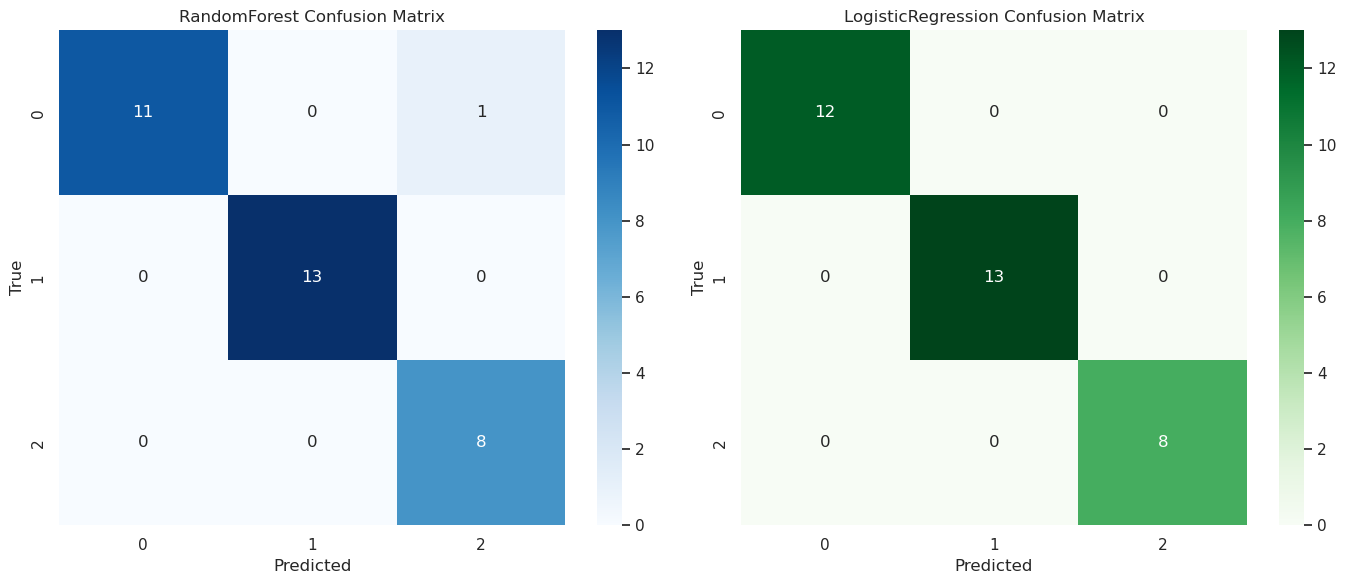

In [38]:
# Confusion Matrices
cm_rf = confusion_matrix(y_true_rf, y_pred_rf)
cm_lr = confusion_matrix(y_true_lr, y_pred_lr)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('RandomForest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('LogisticRegression Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


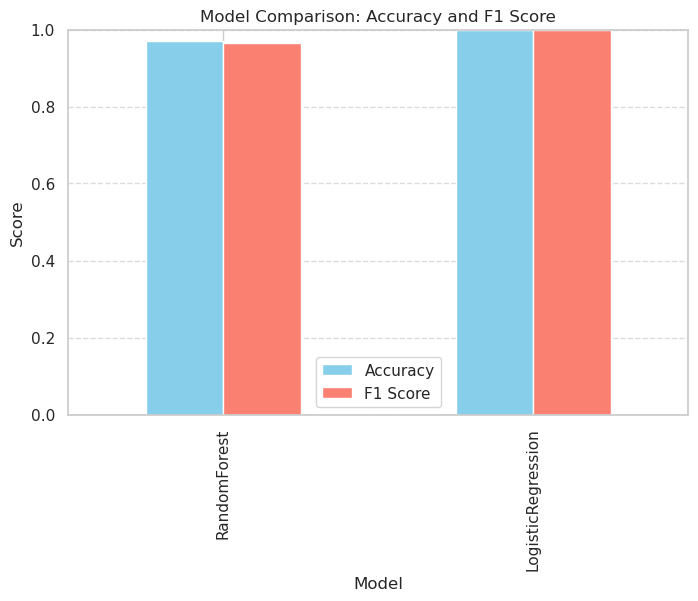

In [40]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['RandomForest', 'LogisticRegression'],
    'Accuracy': [acc_rf, acc_lr],
    'F1 Score': [f1_rf, f1_lr]
})

# Bar chart comparison
comparison_df.set_index('Model')[['Accuracy', 'F1 Score']].plot.bar(figsize=(8, 5), color=['skyblue', 'salmon'])
plt.title('Model Comparison: Accuracy and F1 Score')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

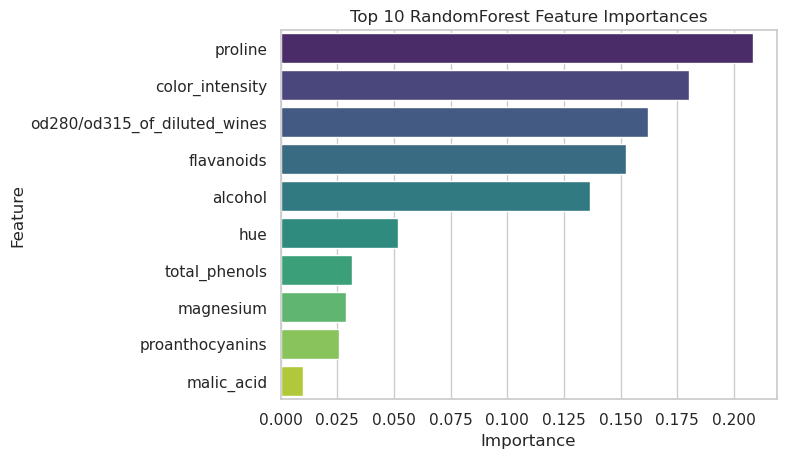

In [42]:
# Feature Importance for RandomForest
rf_model = best_rf.stages[-1]  # Get the RandomForestClassifier from the pipeline
importances = rf_model.featureImportances
features = wine.feature_names
importance_df = pd.DataFrame(list(zip(features, importances)), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot top 10 important features
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Top 10 RandomForest Feature Importances')
plt.show()

🔹 Coefficients for each class (Logistic Regression):


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,-0.481985,-0.188226,-0.230104,0.209936,-0.120007,0.011416,0.066761,0.052316,0.153141,-0.447753,0.262887,0.115636,-0.447500
1,0.374048,0.001049,0.124564,-0.363544,0.058962,0.191186,0.336256,-0.148514,0.062710,0.087915,0.089025,0.288359,0.498737
2,0.107937,0.187176,0.105540,0.153608,0.061045,-0.202602,-0.403017,0.096198,-0.215851,0.359838,-0.351912,-0.403995,-0.051237


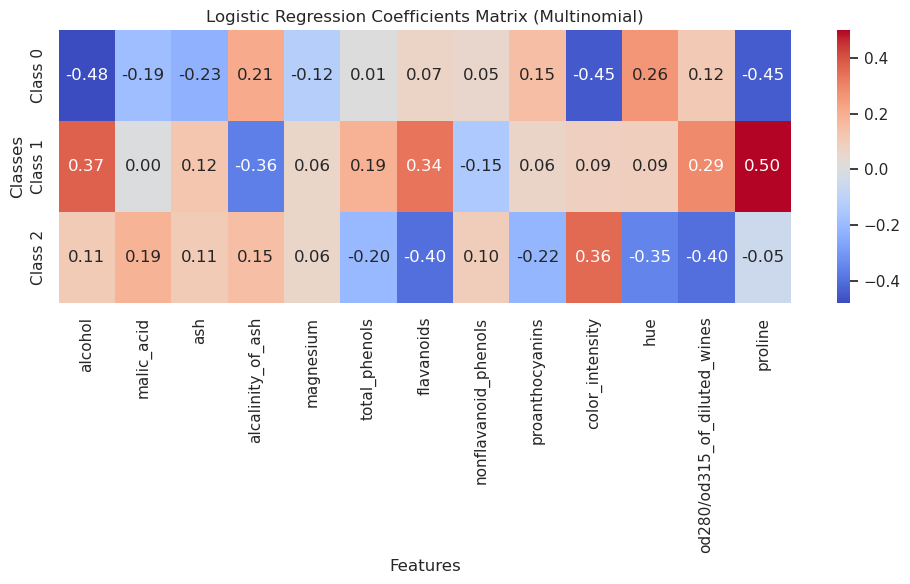

In [44]:
# Step 1: Access the Logistic Regression Model (no 'bestModel' needed)
lr_model = best_lr.stages[-1]  # Access the final Logistic Regression model after the pipeline

# Step 2: Extract coefficients for multinomial Logistic Regression
coeff_matrix = lr_model.coefficientMatrix  # This is used for multinomial logistic regression

# Convert the coefficient matrix to a pandas DataFrame
coeff_df = pd.DataFrame(coeff_matrix.toArray(), columns=feature_cols)

# Display the coefficients for each class
print("🔹 Coefficients for each class (Logistic Regression):")
display(coeff_df)

# Step 3: Visualize the coefficients for each class (heatmap)
plt.figure(figsize=(10, 6))
sns.heatmap(coeff_df, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=feature_cols, yticklabels=['Class ' + str(i) for i in range(coeff_df.shape[0])])
plt.title('Logistic Regression Coefficients Matrix (Multinomial)')
plt.xlabel('Features')
plt.ylabel('Classes')
plt.tight_layout()
plt.show()

In [46]:
if acc_rf > acc_lr and f1_rf > f1_lr:
    print("✅ RandomForest performs better overall with higher accuracy and F1-score.")
elif acc_rf < acc_lr and f1_rf < f1_lr:
    print("✅ LogisticRegression performs better overall with higher accuracy and F1-score.")
else:
    print("⚖️ Both models perform comparably; RandomForest might generalize better for nonlinear patterns.")

✅ LogisticRegression performs better overall with higher accuracy and F1-score.


In [50]:
# Create directory if not exists
import os
os.makedirs("saved_models", exist_ok=True)

# Save Random Forest Model
best_rf.write().overwrite().save("saved_models/pyspark_random_forest.pkl")

# Save Logistic Regression Model
best_lr.write().overwrite().save("saved_models/pyspark_logistic_regression.pkl")

print("PySpark models saved successfully!")

PySpark models saved successfully!


In [57]:
import joblib
import os
model.write().overwrite().save("folder")


joblib.dump(best_lr, "saved_models/logistic_regression.pkl")
joblib.dump(best_rf, "saved_models/random_forest.pkl")

print("Models saved!")


NameError: name 'model' is not defined